# Problem Set 5 - Matias Castro Tapia

In [1]:
import numpy as np
import camb
from matplotlib import pyplot as plt
import time

C:\Users\Odette\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


First, I tried the code planck_likelihood.py provided in the mcmc folder. I copied the code below.

chisq is  15267.937150261656  for  2501  degrees of freedom.


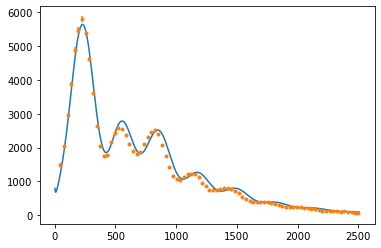

In [2]:
def get_spectrum(pars,lmax=3000):
    #print('pars are ',pars)
    H0=pars[0]
    ombh2=pars[1]
    omch2=pars[2]
    tau=pars[3]
    As=pars[4]
    ns=pars[5]
    pars=camb.CAMBparams()
    pars.set_cosmology(H0=H0,ombh2=ombh2,omch2=omch2,mnu=0.06,omk=0,tau=tau)
    pars.InitPower.set_params(As=As,ns=ns,r=0)
    pars.set_for_lmax(lmax,lens_potential_accuracy=0)
    results=camb.get_results(pars)
    powers=results.get_cmb_power_spectra(pars,CMB_unit='muK')
    cmb=powers['total']
    tt=cmb[:,0]    #you could return the full power spectrum here if you wanted to do say EE
    return tt[2:]


#plt.ion()

pars=np.asarray([60,0.02,0.1,0.05,2.00e-9,1.0])
planck=np.loadtxt('COM_PowerSpect_CMB-TT-full_R3.01.txt',skiprows=1)
ell=planck[:,0]
spec=planck[:,1]
errs=0.5*(planck[:,2]+planck[:,3]);
model=get_spectrum(pars)
model=model[:len(spec)]
resid=spec-model
chisq=np.sum( (resid/errs)**2)
print("chisq is ",chisq," for ",len(resid)-len(pars)," degrees of freedom.")
#read in a binned version of the Planck PS for plotting purposes
planck_binned=np.loadtxt('COM_PowerSpect_CMB-TT-binned_R3.01.txt',skiprows=1)
errs_binned=0.5*(planck_binned[:,2]+planck_binned[:,3]);
#plt.clf()
plt.plot(ell,model)
plt.errorbar(planck_binned[:,0],planck_binned[:,1],errs_binned,fmt='.')
plt.show()

Then, I tried obtaining the model using the set of parameters [69,0.022,0.12,0.06,2.10e-9,0.95].

In [3]:
pars=np.asarray([69,0.022,0.12,0.06,2.10e-9,0.95])
model=get_spectrum(pars)
model=model[:len(spec)]
resid=spec-model
chisq=np.sum( (resid/errs)**2)
print("chisq is ",chisq," for ",len(resid)-len(pars)," degrees of freedom.")

chisq is  3272.2053559202204  for  2501  degrees of freedom.


In [4]:
np.sqrt(2*2501),2501+np.sqrt(2*2501),2501+11*np.sqrt(2*2501)

(70.7248188403477, 2571.724818840348, 3278.9730072438247)

I obtained $\chi^{2}=3272.2053559202204$. Since, there are $2501$ degrees of freedom and the variance of the $\chi^{2}$ is 2 times the degrees of freedom, then $\sigma_{\chi^{2}}=70.72481$. The $\chi^{2}$ obtained with this set of parameters is not good enough since this is very out from the expected (mean) value of $\chi^{2}$, which should be about the value of degrees of freedom. However, this value is much better than the $15267.937150261656$ obtained for the trial in planck_likelihood.py. Thus, this new set of parameters is more likely than the first se since is closer to the $n$ degrees of freedom. 

I defined  the routine ev_planck to obtain the model spectrum using the get_spectrum routine from planck_likelihood.py. ev_planck returns the model with the length of the data in the first column of COM_PowerSpect_CMB-TT-full_R3.01.txt

I also defined the routine deriv to obtain the numerical partial derivatives of a function $G$ as follows:
$$\frac{\partial G}{\partial m_{i}}=\frac{G(x,y,m_{1},...m_{i}+h_{i},...,m_{n})-G(x,y,m_{1},...m_{i}-h_{i},...,m_{n})}{2h_{i}}$$
This beause all the parameters have different orders of magnitude. hh is an array with different scales of $h$ to estimate every numerical partial derivative using a h smaller than the order of magnitude that we already used for each parameter. 

In [5]:
def ev_planck(p):
    model=get_spectrum(p)
    model=model[:len(spec)]
    return model

In [6]:
def deriv(fun,p,h):
    y=fun(p)
    derivs=[]
    for i in range(len(p)):
        pl=p.copy()
        pm=p.copy()
        pl[i]=p[i]+h[i]
        pm[i]=p[i]-h[i]
        derivs.append((fun(pl)-fun(pm))/(2*h[i]))
    return y,np.array(derivs)

In [54]:
hh=np.array([1,0.001,0.01,0.01,1e-11,0.05])/1000

I defined Ninv to be $N^{-1}$ of the data, so every element of the diagonal is $1/\sigma_{i}^{2}$ (and 0 for any other element out of the diagonal due to we are considering uncorrelated) with $\sigma_{i}$ the error obtained from the data as $(\sigma_{i+}+\sigma_{i-})/2$.

In [55]:
Ninv=np.eye(len(errs))*(1/errs**2)

Then, I used the Newton's method to find a root of $\nabla\chi^{2}$ for the set of parameters $m$. Then, the iterative method can be applied using a Taylor expansion for $A(m)=A(m_{0})+A'(m_{0})\delta{m}$, and considering the residual $r=d-A(m)$, the new definition for $\chi^{2}=(r-A'(m_{0}))^{T}N^{-1}(r-A'(m_{0}))$. And asuming that $\delta{m}$ is very small we want to solve $\nabla{\chi^{2}}=-A'^{T}(m_{0})N^{-1}(r-A'(m_{0})\delta{m})=0$. Thus, $\delta{m}=(A'^{T}(m_{0})N^{-1}A'(m_{0}))^{-1}A'^{T}(m_{0})N^{-1}r$, and the iteration for finding a root of $\nabla{\chi^{2}}$ is $m_{n+1}=m_{n}+\delta{m}$.

I also used the $QR$ decomposition for $A'(m_{0})$, then the estimation of $\delta m$ is:
$$\delta m=R^{-1}(Q^{T}N^{-1}Q)^{-1}Q^{T}N^{-1}r$$
The parameters and errors are reported in planck_fit_params.txt.

In [115]:
p=pars.copy()
for j in range(20):
    y,der=deriv(ev_planck,p,hh)
    r=(spec-y)
    chisq=np.sum(((spec-y)**2)/(errs**2))
    A_m=np.ones([r.size,6])
    for i in range(6):
        A_m[:,i]=der[i]
    Q,R=np.linalg.qr(A_m)
   
    dp=np.linalg.inv(R)@np.linalg.inv(Q.T@Ninv@Q)@Q.T@Ninv@r
    for i in range(p.size):
        p[i]=p[i]+dp[i]
    errp=np.sqrt(np.diag(np.linalg.inv(A_m.T@Ninv@A_m)))
    Nm=np.linalg.inv(A_m.T@Ninv@A_m)
    with open('planck_fit_params.txt', 'a') as f:
        for k in p:
            f.write(str(k)+' ')
        for l in errp[0:-1]:
            f.write(str(l)+' ')
        f.write(str(errp[-1])+'\n')      
    print(p,chisq,dp)
print(np.linalg.inv(A_m.T@Ninv@A_m))

[6.84096549e+01 2.23788375e-02 1.17209772e-01 1.10939419e-01
 2.32047535e-09 9.74723324e-01] 3272.2053559202204 [-5.90345079e-01  3.78837531e-04 -2.79022778e-03  5.09394193e-02
  2.20475345e-10  2.47233243e-02]
[6.80579394e+01 2.23426183e-02 1.18078528e-01 7.81984753e-02
 2.18619821e-09 9.71923541e-01] 2588.866733282199 [-3.51715504e-01 -3.62192698e-05  8.68755905e-04 -3.27409440e-02
 -1.34277132e-10 -2.79978335e-03]
[6.82788021e+01 2.23680389e-02 1.17584247e-01 8.71060898e-02
 2.22593152e-09 9.73239361e-01] 2577.7807103445516 [ 2.20862712e-01  2.54205935e-05 -4.94281597e-04  8.90761451e-03
  3.97333066e-11  1.31582022e-03]
[6.82184685e+01 2.23608146e-02 1.17720837e-01 8.43582833e-02
 2.21484870e-09 9.72920900e-01] 2576.171505406044 [-6.03336580e-02 -7.22424601e-06  1.36590662e-04 -2.74780646e-03
 -1.10828220e-11 -3.18460851e-04]
[6.82751928e+01 2.23668709e-02 1.17592617e-01 8.58049092e-02
 2.22056415e-09 9.73221216e-01] 2576.152539126421 [ 5.67243302e-02  6.05632379e-06 -1.28220318e-0

In [116]:
p,errp

(array([6.82416236e+01, 2.23638984e-02, 1.17669875e-01, 8.51333156e-02,
        2.21802047e-09, 9.73041130e-01]),
 array([1.18632544e+00, 2.28910732e-04, 2.65264455e-03, 3.41070114e-02,
        1.43163834e-10, 6.56624303e-03]))

After 20 iterations the change in the parameters is about $m_{i}\times10^{-3}$ and about $0.001$ in the $\chi^{2}$, then, the parameters obtained were $H_{0}=6.82416236e+01$, $\Omega_{b}h^{2}=2.23638984e-02$, $\Omega_{c}h^{2}=1.17669875e-01$, $\tau=8.51333156e-02$, $A_{s}=2.21802047e-09$, $n_{s}=9.73041130e-01$. And the errors: $\sigma_{H_{0}}=1.18632544e+00$, $\sigma_{\Omega_{b}h^{2}}=2.28910732e-04$, $\sigma_{\Omega_{c}h^{2}}=2.65264455e-03$, $\sigma_{\tau}=3.41070114e-02$, $\sigma_{A_{s}}=1.43163834e-10$, $\sigma_{n_{s}}=6.56624303e-03$.

In [58]:
Nm

array([[ 1.40736806e+00,  1.91980999e-04, -3.07098491e-03,
         2.24717010e-02,  8.31440168e-11,  6.89892617e-03],
       [ 1.91980999e-04,  5.24001233e-08, -3.52274631e-07,
         2.98035612e-06,  1.14679314e-14,  7.42832963e-07],
       [-3.07098491e-03, -3.52274631e-07,  7.03652313e-06,
        -4.93716268e-05, -1.80350373e-13, -1.56028162e-05],
       [ 2.24717010e-02,  2.98035612e-06, -4.93716268e-05,
         1.16328823e-03,  4.86410039e-12,  1.24144088e-04],
       [ 8.31440168e-11,  1.14679314e-14, -1.80350373e-13,
         4.86410039e-12,  2.04958833e-20,  4.56870493e-13],
       [ 6.89892617e-03,  7.42832963e-07, -1.56028162e-05,
         1.24144088e-04,  4.56870493e-13,  4.31155476e-05]])

The error in the parameters are obtained from the curvature matrix $N_{m}=(A'N^{-1}A')^{-1}$.

I defined the routine chi2 to calculate the $\chi^{2}$ and the noise routine to calculate the shift of the parameters. I used np.random.multivariate_normal and $N_{m}$ to generate some parameters shifted proportionally to their covariance matrix in the below description of the MCMC routine.

In [59]:
def chi2(theta,d):
    yy=ev_planck(theta)      
    return (d-yy)@(Ninv@(d-yy))

In [60]:
def noise(Nm):   
    return(np.random.multivariate_normal([0]*len(Nm),Nm))

In [61]:
noise(Nm)

array([-1.47734368e+00, -2.62899969e-05,  3.92482603e-03, -3.92610312e-02,
       -1.47506102e-10, -7.12626926e-03])

I defined the routine run_mcmc to run a chain. The routine computes the $\chi^{2}$ for the starting guess, then shifts the parameters using the noise routine and computes the $\chi^{2}$ for the new set of parameters. The routine computes a probability $e^{-0.5\Delta{\chi^{2}}}$ (with $\Delta{\chi^{2}}=\Delta{\chi_{n}^{2}}-\Delta{\chi_{n-1}^{2}}$) and accepts and adds the parameters to the chain just if the probability is greater than a random value between 0 and 1. If the new $\chi^{2}$ is lower than the old, the 'probability' obtained will be always greater than 1 and the new set of parameters will be added to the chain. If the new set of parameters is not accepted, then the new position in the chain will be equal to the previous one. The routine iterates and compares with the previous step for nsteps and finally returns the parameters in the chain along with the $\chi^{2}$ for every case. After some trials I ran the MCMC for 25000 steps. Also, an optimal scale for shifting the parameters and finding an apparent convergence of the chain was noise(Nm)$\times$[0.8,0.8,0.8,0.45,0.45,0.8]. This was obtained trying 1000 steps multiple times, printing the acceptance ratio in the chain, and looking how the parameters change in every step. An optimal acceptance ratio was about $28\%$. The starting guess was the  optimal values obtained from the Newton's method.

In [31]:
def run_mcmc(data,start_pos,nstep,Nm,scale=None):
    nparam=start_pos.size
    params=np.zeros([nstep,nparam+1])
    params[0,0:-1]=start_pos
    cur_chisq=chi2(start_pos,data)
    params[0,-1]=cur_chisq
    cur_pos=start_pos.copy()
    if scale[0]==None:
        scale=np.ones(nparam)
    naccept=0
    accept_rate=np.zeros(nstep)
    for i in range(1,nstep):
        new_pos=cur_pos+noise(Nm)*scale
        new_chisq=chi2(new_pos,data)
        print('Step:',i)
        delt=new_chisq-cur_chisq
        prob=np.exp(-0.5*delt)
        print('prob='+str(prob))
        if np.random.rand()<prob:
                accept=True
        else:
                accept=False
        if accept:
            cur_pos=new_pos
            cur_chisq=new_chisq
            naccept += 1

        accept_rate[i] = naccept / i
        print('acc rate:'+str(accept_rate[i]))
        params[i,0:-1]=cur_pos
        params[i,-1]=cur_chisq
        print(params[i])
        #with open('planck_chain.txt', 'a') as f:
         #   for j in params[i,0:-1]:
          #      f.write(str(j)+' ')
           # f.write(str(params[i,-1])+'\n')
    return params

In [101]:
parrs=np.array([6.82416236e+01,2.23638984e-02,1.17669875e-01,8.51333156e-02,2.21802047e-09,9.73041130e-01])

In [105]:
#chain=run_mcmc(spec,parrs,400,Nm,np.array([0.7,0.7,0.7,0.3,0.3,0.7]))#np.array([1.1,1.1,1.1,0.7,0.7,1.1]))#,np.ones(6)*1.5)
#chain=run_mcmc(spec,parrs,1000,Nm,np.array([0.7,0.7,0.7,0.4,0.4,0.7]))
chaint=run_mcmc(spec,parrs,1000,Nm,np.array([0.8,0.8,0.8,0.45,0.45,0.8]))

Step: 1
prob=0.2866652143878239
acc rate:0.0
[6.82522094e+01 2.23649711e-02 1.17644872e-01 8.57380247e-02
 2.22052849e-09 9.73103260e-01 2.57615334e+03]
Step: 2
prob=4.9306144354473415e-05
acc rate:0.0
[6.82522094e+01 2.23649711e-02 1.17644872e-01 8.57380247e-02
 2.22052849e-09 9.73103260e-01 2.57615334e+03]
Step: 3
prob=0.2601293190137048
acc rate:0.0
[6.82522094e+01 2.23649711e-02 1.17644872e-01 8.57380247e-02
 2.22052849e-09 9.73103260e-01 2.57615334e+03]
Step: 4
prob=8.673850947350423e-07
acc rate:0.0
[6.82522094e+01 2.23649711e-02 1.17644872e-01 8.57380247e-02
 2.22052849e-09 9.73103260e-01 2.57615334e+03]
Step: 5
prob=0.13912380245631745
acc rate:0.0
[6.82522094e+01 2.23649711e-02 1.17644872e-01 8.57380247e-02
 2.22052849e-09 9.73103260e-01 2.57615334e+03]
Step: 6
prob=0.296463391833597
acc rate:0.0
[6.82522094e+01 2.23649711e-02 1.17644872e-01 8.57380247e-02
 2.22052849e-09 9.73103260e-01 2.57615334e+03]
Step: 7
prob=0.0008665496502199987
acc rate:0.0
[6.82522094e+01 2.23649711e

Step: 51
prob=2.030698701685821
acc rate:0.2549019607843137
[6.87894349e+01 2.25541904e-02 1.16382645e-01 8.20918489e-02
 2.19732550e-09 9.74492308e-01 2.57804815e+03]
Step: 52
prob=0.031914401070182445
acc rate:0.25
[6.87894349e+01 2.25541904e-02 1.16382645e-01 8.20918489e-02
 2.19732550e-09 9.74492308e-01 2.57804815e+03]
Step: 53
prob=0.023426330080921057
acc rate:0.24528301886792453
[6.87894349e+01 2.25541904e-02 1.16382645e-01 8.20918489e-02
 2.19732550e-09 9.74492308e-01 2.57804815e+03]
Step: 54
prob=0.025795038876035348
acc rate:0.24074074074074073
[6.87894349e+01 2.25541904e-02 1.16382645e-01 8.20918489e-02
 2.19732550e-09 9.74492308e-01 2.57804815e+03]
Step: 55
prob=0.002740040816992501
acc rate:0.23636363636363636
[6.87894349e+01 2.25541904e-02 1.16382645e-01 8.20918489e-02
 2.19732550e-09 9.74492308e-01 2.57804815e+03]
Step: 56
prob=0.10664544422262066
acc rate:0.23214285714285715
[6.87894349e+01 2.25541904e-02 1.16382645e-01 8.20918489e-02
 2.19732550e-09 9.74492308e-01 2.57

Step: 100
prob=3.407710982283189
acc rate:0.25
[6.94244438e+01 2.22185142e-02 1.14518001e-01 8.03160494e-02
 2.17641669e-09 9.83142442e-01 2.58230420e+03]
Step: 101
prob=0.01004263058045681
acc rate:0.24752475247524752
[6.94244438e+01 2.22185142e-02 1.14518001e-01 8.03160494e-02
 2.17641669e-09 9.83142442e-01 2.58230420e+03]
Step: 102
prob=0.24510849551824207
acc rate:0.24509803921568626
[6.94244438e+01 2.22185142e-02 1.14518001e-01 8.03160494e-02
 2.17641669e-09 9.83142442e-01 2.58230420e+03]
Step: 103
prob=2.5485830011051456
acc rate:0.2524271844660194
[6.89527176e+01 2.23743062e-02 1.16059396e-01 8.82202015e-02
 2.21852850e-09 9.76233169e-01 2.58043312e+03]
Step: 104
prob=0.16582580814741593
acc rate:0.25
[6.89527176e+01 2.23743062e-02 1.16059396e-01 8.82202015e-02
 2.21852850e-09 9.76233169e-01 2.58043312e+03]
Step: 105
prob=0.06462119834063439
acc rate:0.24761904761904763
[6.89527176e+01 2.23743062e-02 1.16059396e-01 8.82202015e-02
 2.21852850e-09 9.76233169e-01 2.58043312e+03]
St

Step: 149
prob=2.910272742690809e-06
acc rate:0.2684563758389262
[6.95079389e+01 2.24809899e-02 1.14509182e-01 1.27995035e-01
 2.38718369e-09 9.82237812e-01 2.58348861e+03]
Step: 150
prob=0.017567027739248967
acc rate:0.26666666666666666
[6.95079389e+01 2.24809899e-02 1.14509182e-01 1.27995035e-01
 2.38718369e-09 9.82237812e-01 2.58348861e+03]
Step: 151
prob=0.00018382521114581777
acc rate:0.26490066225165565
[6.95079389e+01 2.24809899e-02 1.14509182e-01 1.27995035e-01
 2.38718369e-09 9.82237812e-01 2.58348861e+03]
Step: 152
prob=0.041003519162110855
acc rate:0.2631578947368421
[6.95079389e+01 2.24809899e-02 1.14509182e-01 1.27995035e-01
 2.38718369e-09 9.82237812e-01 2.58348861e+03]
Step: 153
prob=0.806613246221103
acc rate:0.2679738562091503
[6.97110292e+01 2.25218292e-02 1.13986005e-01 1.29281092e-01
 2.39030571e-09 9.83377024e-01 2.58391843e+03]
Step: 154
prob=2.0340089217069654e-05
acc rate:0.2662337662337662
[6.97110292e+01 2.25218292e-02 1.13986005e-01 1.29281092e-01
 2.39030571

Step: 197
prob=0.003917137276856797
acc rate:0.29441624365482233
[7.01063910e+01 2.24942249e-02 1.13544668e-01 1.09413311e-01
 2.31222764e-09 9.80204063e-01 2.58240947e+03]
Step: 198
prob=3.4498668576432947
acc rate:0.29797979797979796
[6.87908138e+01 2.22154084e-02 1.15801949e-01 8.82011450e-02
 2.22364606e-09 9.77673063e-01 2.57993280e+03]
Step: 199
prob=0.40269930465392084
acc rate:0.2964824120603015
[6.87908138e+01 2.22154084e-02 1.15801949e-01 8.82011450e-02
 2.22364606e-09 9.77673063e-01 2.57993280e+03]
Step: 200
prob=0.3241016335377977
acc rate:0.3
[6.83517929e+01 2.20667690e-02 1.16266263e-01 7.40236671e-02
 2.16414971e-09 9.74373397e-01 2.58218619e+03]
Step: 201
prob=2.0676258240894922
acc rate:0.3034825870646766
[6.80679212e+01 2.21044713e-02 1.17378368e-01 5.75769394e-02
 2.09593862e-09 9.71762463e-01 2.58073339e+03]
Step: 202
prob=0.004510351932735232
acc rate:0.30198019801980197
[6.80679212e+01 2.21044713e-02 1.17378368e-01 5.75769394e-02
 2.09593862e-09 9.71762463e-01 2.5

Step: 245
prob=0.004738980616076386
acc rate:0.30612244897959184
[6.93949646e+01 2.23550803e-02 1.14736061e-01 1.20212834e-01
 2.36149725e-09 9.79104487e-01 2.57905562e+03]
Step: 246
prob=0.5834345454367806
acc rate:0.3048780487804878
[6.93949646e+01 2.23550803e-02 1.14736061e-01 1.20212834e-01
 2.36149725e-09 9.79104487e-01 2.57905562e+03]
Step: 247
prob=6.717964284558665e-05
acc rate:0.30364372469635625
[6.93949646e+01 2.23550803e-02 1.14736061e-01 1.20212834e-01
 2.36149725e-09 9.79104487e-01 2.57905562e+03]
Step: 248
prob=0.005477418800338838
acc rate:0.3024193548387097
[6.93949646e+01 2.23550803e-02 1.14736061e-01 1.20212834e-01
 2.36149725e-09 9.79104487e-01 2.57905562e+03]
Step: 249
prob=0.04534518785332788
acc rate:0.30120481927710846
[6.93949646e+01 2.23550803e-02 1.14736061e-01 1.20212834e-01
 2.36149725e-09 9.79104487e-01 2.57905562e+03]
Step: 250
prob=0.4249923362441328
acc rate:0.3
[6.93949646e+01 2.23550803e-02 1.14736061e-01 1.20212834e-01
 2.36149725e-09 9.79104487e-01 

Step: 294
prob=0.06026786120475217
acc rate:0.2755102040816326
[6.87135593e+01 2.25115419e-02 1.16592849e-01 1.07370670e-01
 2.31010126e-09 9.75328618e-01 2.57771938e+03]
Step: 295
prob=0.35580356896169246
acc rate:0.2745762711864407
[6.87135593e+01 2.25115419e-02 1.16592849e-01 1.07370670e-01
 2.31010126e-09 9.75328618e-01 2.57771938e+03]
Step: 296
prob=0.5415460005160169
acc rate:0.27702702702702703
[6.78257825e+01 2.22760948e-02 1.18215476e-01 9.39416476e-02
 2.25380326e-09 9.75180711e-01 2.57894604e+03]
Step: 297
prob=0.03314845420604229
acc rate:0.27946127946127947
[6.90156967e+01 2.22622000e-02 1.15292258e-01 1.16261096e-01
 2.34035648e-09 9.85401190e-01 2.58575955e+03]
Step: 298
prob=0.0408129448661905
acc rate:0.28187919463087246
[6.90636875e+01 2.23632636e-02 1.15036491e-01 1.27694287e-01
 2.38802816e-09 9.87881283e-01 2.59215707e+03]
Step: 299
prob=0.5832654170692247
acc rate:0.2842809364548495
[6.86116909e+01 2.22411394e-02 1.15488322e-01 1.39113460e-01
 2.44015704e-09 9.807

Step: 342
prob=0.15212940389494958
acc rate:0.29239766081871343
[6.80555274e+01 2.26735454e-02 1.18687609e-01 7.21983273e-02
 2.16025347e-09 9.72309638e-01 2.58493223e+03]
Step: 343
prob=0.0009293682398705213
acc rate:0.2915451895043732
[6.80555274e+01 2.26735454e-02 1.18687609e-01 7.21983273e-02
 2.16025347e-09 9.72309638e-01 2.58493223e+03]
Step: 344
prob=15.46375223542992
acc rate:0.2936046511627907
[6.83580718e+01 2.25419723e-02 1.17559984e-01 7.95076383e-02
 2.18766703e-09 9.74332850e-01 2.57945523e+03]
Step: 345
prob=0.2619790289578248
acc rate:0.2927536231884058
[6.83580718e+01 2.25419723e-02 1.17559984e-01 7.95076383e-02
 2.18766703e-09 9.74332850e-01 2.57945523e+03]
Step: 346
prob=0.06912210398165383
acc rate:0.2947976878612717
[6.81434546e+01 2.23654085e-02 1.17005303e-01 7.78249459e-02
 2.17989052e-09 9.76519623e-01 2.58479899e+03]
Step: 347
prob=0.00024876346764204346
acc rate:0.29394812680115273
[6.81434546e+01 2.23654085e-02 1.17005303e-01 7.78249459e-02
 2.17989052e-09 9

Step: 390
prob=0.5476051298507112
acc rate:0.2846153846153846
[6.86549310e+01 2.25850604e-02 1.16720429e-01 4.87957556e-02
 2.05520669e-09 9.72589397e-01 2.58351942e+03]
Step: 391
prob=0.003447405166370894
acc rate:0.28388746803069054
[6.86549310e+01 2.25850604e-02 1.16720429e-01 4.87957556e-02
 2.05520669e-09 9.72589397e-01 2.58351942e+03]
Step: 392
prob=0.07293333581245443
acc rate:0.28316326530612246
[6.86549310e+01 2.25850604e-02 1.16720429e-01 4.87957556e-02
 2.05520669e-09 9.72589397e-01 2.58351942e+03]
Step: 393
prob=0.195787473682242
acc rate:0.28498727735368956
[6.98355059e+01 2.28830585e-02 1.14526258e-01 5.23102267e-02
 2.06398578e-09 9.78420674e-01 2.58678088e+03]
Step: 394
prob=4.036236402365623e-06
acc rate:0.28426395939086296
[6.98355059e+01 2.28830585e-02 1.14526258e-01 5.23102267e-02
 2.06398578e-09 9.78420674e-01 2.58678088e+03]
Step: 395
prob=0.025336710579795346
acc rate:0.28354430379746837
[6.98355059e+01 2.28830585e-02 1.14526258e-01 5.23102267e-02
 2.06398578e-09

Step: 438
prob=0.03664059867689815
acc rate:0.2785388127853881
[6.94180041e+01 2.26014049e-02 1.15230038e-01 1.13542295e-01
 2.33607690e-09 9.73919510e-01 2.58139153e+03]
Step: 439
prob=1.948146785072874
acc rate:0.28018223234624146
[6.98057043e+01 2.25263658e-02 1.13923583e-01 1.19429802e-01
 2.35609550e-09 9.78629557e-01 2.58005777e+03]
Step: 440
prob=0.004251976239157637
acc rate:0.27954545454545454
[6.98057043e+01 2.25263658e-02 1.13923583e-01 1.19429802e-01
 2.35609550e-09 9.78629557e-01 2.58005777e+03]
Step: 441
prob=0.22203370131318856
acc rate:0.2789115646258503
[6.98057043e+01 2.25263658e-02 1.13923583e-01 1.19429802e-01
 2.35609550e-09 9.78629557e-01 2.58005777e+03]
Step: 442
prob=0.20036932664798543
acc rate:0.27828054298642535
[6.98057043e+01 2.25263658e-02 1.13923583e-01 1.19429802e-01
 2.35609550e-09 9.78629557e-01 2.58005777e+03]
Step: 443
prob=3.285692691868496e-05
acc rate:0.27765237020316025
[6.98057043e+01 2.25263658e-02 1.13923583e-01 1.19429802e-01
 2.35609550e-09 

Step: 486
prob=0.09175042307166952
acc rate:0.2757201646090535
[6.90492062e+01 2.23725671e-02 1.16418944e-01 8.41089581e-02
 2.20524459e-09 9.76313796e-01 2.58283491e+03]
Step: 487
prob=0.5322010892238684
acc rate:0.27720739219712526
[6.89796347e+01 2.22367212e-02 1.16314050e-01 7.77176766e-02
 2.17529991e-09 9.79106193e-01 2.58409638e+03]
Step: 488
prob=0.1113361203238692
acc rate:0.2766393442622951
[6.89796347e+01 2.22367212e-02 1.16314050e-01 7.77176766e-02
 2.17529991e-09 9.79106193e-01 2.58409638e+03]
Step: 489
prob=0.05023454968985436
acc rate:0.27607361963190186
[6.89796347e+01 2.22367212e-02 1.16314050e-01 7.77176766e-02
 2.17529991e-09 9.79106193e-01 2.58409638e+03]
Step: 490
prob=0.009523061813450192
acc rate:0.2755102040816326
[6.89796347e+01 2.22367212e-02 1.16314050e-01 7.77176766e-02
 2.17529991e-09 9.79106193e-01 2.58409638e+03]
Step: 491
prob=0.03960184595711227
acc rate:0.27494908350305497
[6.89796347e+01 2.22367212e-02 1.16314050e-01 7.77176766e-02
 2.17529991e-09 9.7

Step: 535
prob=1.1212277560370327
acc rate:0.29158878504672897
[6.79951015e+01 2.23329771e-02 1.17851127e-01 5.63530089e-02
 2.09449564e-09 9.70894358e-01 2.57804967e+03]
Step: 536
prob=0.019827323307689795
acc rate:0.291044776119403
[6.79951015e+01 2.23329771e-02 1.17851127e-01 5.63530089e-02
 2.09449564e-09 9.70894358e-01 2.57804967e+03]
Step: 537
prob=1.0262892463427697
acc rate:0.29236499068901306
[6.77450681e+01 2.21421835e-02 1.18417096e-01 6.10349144e-02
 2.11721272e-09 9.72707926e-01 2.57799777e+03]
Step: 538
prob=0.0018633375066382624
acc rate:0.29182156133828996
[6.77450681e+01 2.21421835e-02 1.18417096e-01 6.10349144e-02
 2.11721272e-09 9.72707926e-01 2.57799777e+03]
Step: 539
prob=0.13324654125673657
acc rate:0.2912801484230056
[6.77450681e+01 2.21421835e-02 1.18417096e-01 6.10349144e-02
 2.11721272e-09 9.72707926e-01 2.57799777e+03]
Step: 540
prob=0.09733361233930564
acc rate:0.29074074074074074
[6.77450681e+01 2.21421835e-02 1.18417096e-01 6.10349144e-02
 2.11721272e-09 9

Step: 583
prob=6.535874818773602e-11
acc rate:0.2864493996569468
[6.83998384e+01 2.22296665e-02 1.16994548e-01 5.74445314e-02
 2.09706007e-09 9.71501417e-01 2.57975758e+03]
Step: 584
prob=1.0430184253440418
acc rate:0.2876712328767123
[6.87398207e+01 2.22901265e-02 1.16053736e-01 4.89905476e-02
 2.05563730e-09 9.75920751e-01 2.57967335e+03]
Step: 585
prob=0.04638461844910099
acc rate:0.28717948717948716
[6.87398207e+01 2.22901265e-02 1.16053736e-01 4.89905476e-02
 2.05563730e-09 9.75920751e-01 2.57967335e+03]
Step: 586
prob=0.00026115877603867673
acc rate:0.28668941979522183
[6.87398207e+01 2.22901265e-02 1.16053736e-01 4.89905476e-02
 2.05563730e-09 9.75920751e-01 2.57967335e+03]
Step: 587
prob=6.412451182066139e-13
acc rate:0.28620102214650767
[6.87398207e+01 2.22901265e-02 1.16053736e-01 4.89905476e-02
 2.05563730e-09 9.75920751e-01 2.57967335e+03]
Step: 588
prob=0.008373943928119191
acc rate:0.2857142857142857
[6.87398207e+01 2.22901265e-02 1.16053736e-01 4.89905476e-02
 2.05563730

Step: 631
prob=0.00037509530465032085
acc rate:0.2900158478605388
[7.03091289e+01 2.25588453e-02 1.12409768e-01 2.48220756e-02
 1.93644251e-09 9.88928720e-01 2.59634307e+03]
Step: 632
prob=0.35378957498290664
acc rate:0.28955696202531644
[7.03091289e+01 2.25588453e-02 1.12409768e-01 2.48220756e-02
 1.93644251e-09 9.88928720e-01 2.59634307e+03]
Step: 633
prob=2.1514701193992214
acc rate:0.29067930489731436
[6.99293651e+01 2.24963227e-02 1.13566578e-01 2.21335334e-02
 1.92730106e-09 9.85364861e-01 2.59481077e+03]
Step: 634
prob=3.043519939937307e-06
acc rate:0.2902208201892745
[6.99293651e+01 2.24963227e-02 1.13566578e-01 2.21335334e-02
 1.92730106e-09 9.85364861e-01 2.59481077e+03]
Step: 635
prob=14.988854748818122
acc rate:0.29133858267716534
[6.96565068e+01 2.24586535e-02 1.14357232e-01 3.55079719e-02
 1.98886337e-09 9.86205761e-01 2.58939615e+03]
Step: 636
prob=0.1363771209054534
acc rate:0.2908805031446541
[6.96565068e+01 2.24586535e-02 1.14357232e-01 3.55079719e-02
 1.98886337e-09 

Step: 679
prob=1.5000178142384935
acc rate:0.28718703976435933
[6.81478106e+01 2.26205109e-02 1.18254887e-01 7.91624673e-02
 2.19750961e-09 9.72877393e-01 2.58221586e+03]
Step: 680
prob=0.511611617479308
acc rate:0.28823529411764703
[6.79163290e+01 2.25153868e-02 1.18394549e-01 8.21452228e-02
 2.20668142e-09 9.75032823e-01 2.58355624e+03]
Step: 681
prob=0.18097640365739062
acc rate:0.2878120411160059
[6.79163290e+01 2.25153868e-02 1.18394549e-01 8.21452228e-02
 2.20668142e-09 9.75032823e-01 2.58355624e+03]
Step: 682
prob=0.06520876965132502
acc rate:0.2873900293255132
[6.79163290e+01 2.25153868e-02 1.18394549e-01 8.21452228e-02
 2.20668142e-09 9.75032823e-01 2.58355624e+03]
Step: 683
prob=0.11783756232402966
acc rate:0.2869692532942899
[6.79163290e+01 2.25153868e-02 1.18394549e-01 8.21452228e-02
 2.20668142e-09 9.75032823e-01 2.58355624e+03]
Step: 684
prob=0.199534837960027
acc rate:0.28654970760233917
[6.79163290e+01 2.25153868e-02 1.18394549e-01 8.21452228e-02
 2.20668142e-09 9.75032

Step: 727
prob=0.021714660587202825
acc rate:0.28473177441540576
[6.94590161e+01 2.24090381e-02 1.14900011e-01 6.11574999e-02
 2.10267064e-09 9.80329469e-01 2.58122712e+03]
Step: 728
prob=0.13089873300786958
acc rate:0.28434065934065933
[6.94590161e+01 2.24090381e-02 1.14900011e-01 6.11574999e-02
 2.10267064e-09 9.80329469e-01 2.58122712e+03]
Step: 729
prob=8.959873035565682e-05
acc rate:0.2839506172839506
[6.94590161e+01 2.24090381e-02 1.14900011e-01 6.11574999e-02
 2.10267064e-09 9.80329469e-01 2.58122712e+03]
Step: 730
prob=0.08870121390693696
acc rate:0.28356164383561644
[6.94590161e+01 2.24090381e-02 1.14900011e-01 6.11574999e-02
 2.10267064e-09 9.80329469e-01 2.58122712e+03]
Step: 731
prob=6.767355196966658e-05
acc rate:0.28317373461012313
[6.94590161e+01 2.24090381e-02 1.14900011e-01 6.11574999e-02
 2.10267064e-09 9.80329469e-01 2.58122712e+03]
Step: 732
prob=0.23675421838223046
acc rate:0.2827868852459016
[6.94590161e+01 2.24090381e-02 1.14900011e-01 6.11574999e-02
 2.10267064e

Step: 775
prob=0.30179573663842896
acc rate:0.28516129032258064
[6.85385162e+01 2.24105162e-02 1.16643531e-01 7.23465292e-02
 2.15820314e-09 9.73216062e-01 2.57778916e+03]
Step: 776
prob=0.28351607086156844
acc rate:0.2847938144329897
[6.85385162e+01 2.24105162e-02 1.16643531e-01 7.23465292e-02
 2.15820314e-09 9.73216062e-01 2.57778916e+03]
Step: 777
prob=0.11971485769458245
acc rate:0.28442728442728443
[6.85385162e+01 2.24105162e-02 1.16643531e-01 7.23465292e-02
 2.15820314e-09 9.73216062e-01 2.57778916e+03]
Step: 778
prob=0.03322074120156914
acc rate:0.28406169665809766
[6.85385162e+01 2.24105162e-02 1.16643531e-01 7.23465292e-02
 2.15820314e-09 9.73216062e-01 2.57778916e+03]
Step: 779
prob=0.0030923027730667962
acc rate:0.28369704749679076
[6.85385162e+01 2.24105162e-02 1.16643531e-01 7.23465292e-02
 2.15820314e-09 9.73216062e-01 2.57778916e+03]
Step: 780
prob=0.9475460492815374
acc rate:0.2846153846153846
[6.84731868e+01 2.24105381e-02 1.16881007e-01 6.57802196e-02
 2.12837247e-09 

Step: 823
prob=0.08767975455959841
acc rate:0.28554070473876064
[6.90495110e+01 2.23967344e-02 1.15310776e-01 8.67929898e-02
 2.21463271e-09 9.76926867e-01 2.57879579e+03]
Step: 824
prob=0.3338648865111166
acc rate:0.28519417475728154
[6.90495110e+01 2.23967344e-02 1.15310776e-01 8.67929898e-02
 2.21463271e-09 9.76926867e-01 2.57879579e+03]
Step: 825
prob=1.0962234253533933
acc rate:0.28606060606060607
[6.79984064e+01 2.22716244e-02 1.17660667e-01 6.84477096e-02
 2.14229189e-09 9.71356564e-01 2.57861205e+03]
Step: 826
prob=0.2808366870364656
acc rate:0.2857142857142857
[6.79984064e+01 2.22716244e-02 1.17660667e-01 6.84477096e-02
 2.14229189e-09 9.71356564e-01 2.57861205e+03]
Step: 827
prob=0.0010839757063233351
acc rate:0.28536880290205563
[6.79984064e+01 2.22716244e-02 1.17660667e-01 6.84477096e-02
 2.14229189e-09 9.71356564e-01 2.57861205e+03]
Step: 828
prob=0.33870409144675145
acc rate:0.28502415458937197
[6.79984064e+01 2.22716244e-02 1.17660667e-01 6.84477096e-02
 2.14229189e-09 9

Step: 871
prob=4.796122904278925e-05
acc rate:0.2847301951779564
[6.84396712e+01 2.24447286e-02 1.17168172e-01 4.88896669e-02
 2.05859301e-09 9.77548968e-01 2.58145587e+03]
Step: 872
prob=0.09650186853200908
acc rate:0.28440366972477066
[6.84396712e+01 2.24447286e-02 1.17168172e-01 4.88896669e-02
 2.05859301e-09 9.77548968e-01 2.58145587e+03]
Step: 873
prob=0.002306666692611127
acc rate:0.284077892325315
[6.84396712e+01 2.24447286e-02 1.17168172e-01 4.88896669e-02
 2.05859301e-09 9.77548968e-01 2.58145587e+03]
Step: 874
prob=0.322766530130404
acc rate:0.2837528604118993
[6.84396712e+01 2.24447286e-02 1.17168172e-01 4.88896669e-02
 2.05859301e-09 9.77548968e-01 2.58145587e+03]
Step: 875
prob=0.10682894742771754
acc rate:0.2834285714285714
[6.84396712e+01 2.24447286e-02 1.17168172e-01 4.88896669e-02
 2.05859301e-09 9.77548968e-01 2.58145587e+03]
Step: 876
prob=0.12718153626166148
acc rate:0.2831050228310502
[6.84396712e+01 2.24447286e-02 1.17168172e-01 4.88896669e-02
 2.05859301e-09 9.77

Step: 919
prob=0.0024937334835681193
acc rate:0.28182807399347115
[6.93340861e+01 2.27642412e-02 1.15793494e-01 7.58522486e-02
 2.17273195e-09 9.79215508e-01 2.58660934e+03]
Step: 920
prob=23.907718648350688
acc rate:0.2826086956521739
[6.86772866e+01 2.24950178e-02 1.16859525e-01 8.55697307e-02
 2.21748490e-09 9.77643528e-01 2.58026094e+03]
Step: 921
prob=2.1483401053469815
acc rate:0.28338762214983715
[6.77454958e+01 2.24252629e-02 1.18684906e-01 8.67328565e-02
 2.22675690e-09 9.72100455e-01 2.57873155e+03]
Step: 922
prob=1.1216160701772566
acc rate:0.2841648590021692
[6.81466066e+01 2.24171256e-02 1.17798130e-01 1.04431331e-01
 2.30191290e-09 9.75517345e-01 2.57850201e+03]
Step: 923
prob=0.21554228888369706
acc rate:0.28494041170097506
[6.83691988e+01 2.25050668e-02 1.17050966e-01 9.57758700e-02
 2.26187133e-09 9.75587541e-01 2.58157120e+03]
Step: 924
prob=0.4971905327027223
acc rate:0.2857142857142857
[6.77750426e+01 2.22660106e-02 1.18125128e-01 8.43924937e-02
 2.21514671e-09 9.75

Step: 967
prob=0.024578611142564988
acc rate:0.28645294725956566
[7.02302240e+01 2.24311589e-02 1.13605256e-01 1.24823325e-01
 2.37823315e-09 9.84505117e-01 2.58385714e+03]
Step: 968
prob=0.05343413295991076
acc rate:0.28615702479338845
[7.02302240e+01 2.24311589e-02 1.13605256e-01 1.24823325e-01
 2.37823315e-09 9.84505117e-01 2.58385714e+03]
Step: 969
prob=0.00021938274224498415
acc rate:0.28586171310629516
[7.02302240e+01 2.24311589e-02 1.13605256e-01 1.24823325e-01
 2.37823315e-09 9.84505117e-01 2.58385714e+03]
Step: 970
prob=0.008470417930460005
acc rate:0.28556701030927834
[7.02302240e+01 2.24311589e-02 1.13605256e-01 1.24823325e-01
 2.37823315e-09 9.84505117e-01 2.58385714e+03]
Step: 971
prob=0.006660720294572946
acc rate:0.28527291452111225
[7.02302240e+01 2.24311589e-02 1.13605256e-01 1.24823325e-01
 2.37823315e-09 9.84505117e-01 2.58385714e+03]
Step: 972
prob=0.10403761304249576
acc rate:0.28497942386831276
[7.02302240e+01 2.24311589e-02 1.13605256e-01 1.24823325e-01
 2.378233

Text(0.5, 0, 'step')

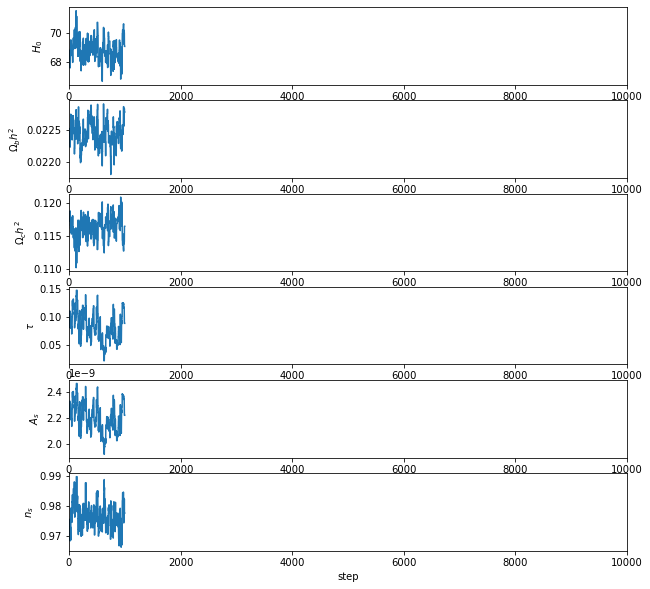

In [109]:
f,ax=plt.subplots(6,1,figsize=(10,10))
par=['$H_{0}$','$\Omega_{b}h^{2}$','$\Omega_{c}h^{2}$',r'$\tau$','$A_{s}$','$n_{s}$']
for i in range(0,6):
    ax[i].plot([chaint[j][i] for j in range(0,len(chaint))],'-')
    ax[i].set_ylabel(par[i])
    ax[i].set_xlim(0,10000)
plt.xlabel('step')

Below I modified the run_mcmc routine to not print every step, but to write the $\chi^{2}$ value and the parameters of each step on the file planck_chain.txt. Once modified I ran the 25000 steps.

In [46]:
def run_mcmc(data,start_pos,nstep,Nm,scale=None):
    nparam=start_pos.size
    params=np.zeros([nstep,nparam+1])
    params[0,0:-1]=start_pos
    cur_chisq=chi2(start_pos,data)
    params[0,-1]=cur_chisq
    cur_pos=start_pos.copy()
    if scale[0]==None:
        scale=np.ones(nparam)
    naccept=0
    accept_rate=np.zeros(nstep)
    for i in range(1,nstep):
        new_pos=cur_pos+noise(Nm)*scale
        new_chisq=chi2(new_pos,data)
        #print('Step:',i)
        delt=new_chisq-cur_chisq
        prob=np.exp(-0.5*delt)
        #print('prob='+str(prob))
        if np.random.rand()<prob:
                accept=True
        else:
                accept=False
        if accept:
            cur_pos=new_pos
            cur_chisq=new_chisq
            naccept += 1

        accept_rate[i] = naccept / i
        #print('acc rate:'+str(accept_rate[i]))
        params[i,0:-1]=cur_pos
        params[i,-1]=cur_chisq
        #print(params[i])
        with open('planck_chain.txt', 'a') as f:
            f.write(str(cur_chisq)+' ')
            for j in cur_pos[0:-1]:
                f.write(str(j)+' ') 
            f.write(str(cur_pos[-1])+'\n')
    return params

In [47]:
chain=run_mcmc(spec,parrs,25000,Nm,np.array([0.8,0.8,0.8,0.45,0.45,0.8]))

Reading the file with the chain saved.

In [13]:
fl=open('planck_chain.txt')
chain=np.array([(x.strip()).split(' ') for x in fl.readlines()],dtype='float64')
fl.close()

In [14]:
chi2m=np.array([chain[j][0] for j in range(0,len(chain))])
H0=np.array([chain[j][1] for j in range(0,len(chain))])
Ob=np.array([chain[j][2] for j in range(0,len(chain))])
Oc=np.array([chain[j][3] for j in range(0,len(chain))])
tau=np.array([chain[j][4] for j in range(0,len(chain))])
As=np.array([chain[j][5] for j in range(0,len(chain))])
ns=np.array([chain[j][6] for j in range(0,len(chain))])

Below we can see that the plots of parameter vs steps almost look like white noise, this means that the parameters have forgotten their initial values, and then the chain should have converged.

Text(0.5, 0, 'step')

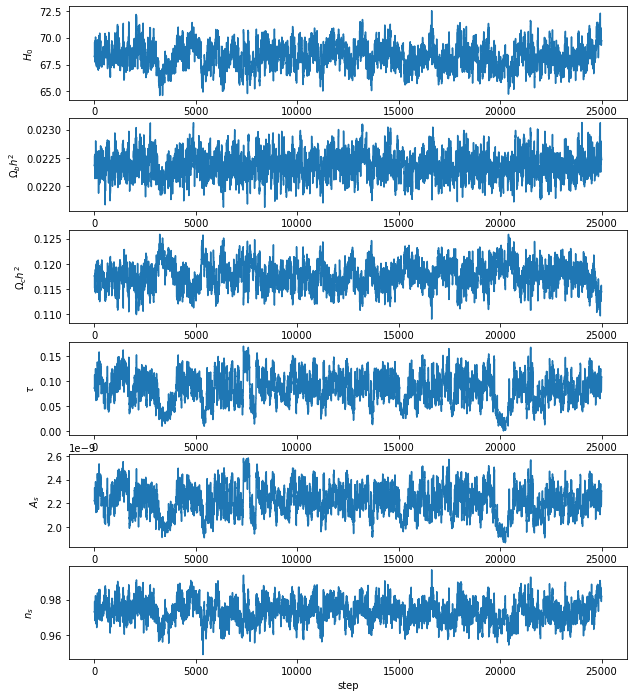

In [15]:
f,ax=plt.subplots(6,1,figsize=(10,12))
par=[r'$H_{0}$',r'$\Omega_{b}h^{2}$',r'$\Omega_{c}h^{2}$',r'$\tau$',r'$A_{s}$',r'$n_{s}$']
for i in range(1,7):
    ax[i-1].plot([chain[j][i] for j in range(0,len(chain))],'-')
    ax[i-1].set_ylabel(par[i-1])
    #ax[i-1].set_xlim(0,10000)
plt.xlabel('step')

Now, using the corner package we can plot the posterior distributions for the parameters along with the scatter of the parameters. Thus, we can also see the correlation between the parameters. 

In [16]:
samples=np.array([H0,Ob,Oc,tau,As,ns])

In [17]:
import corner

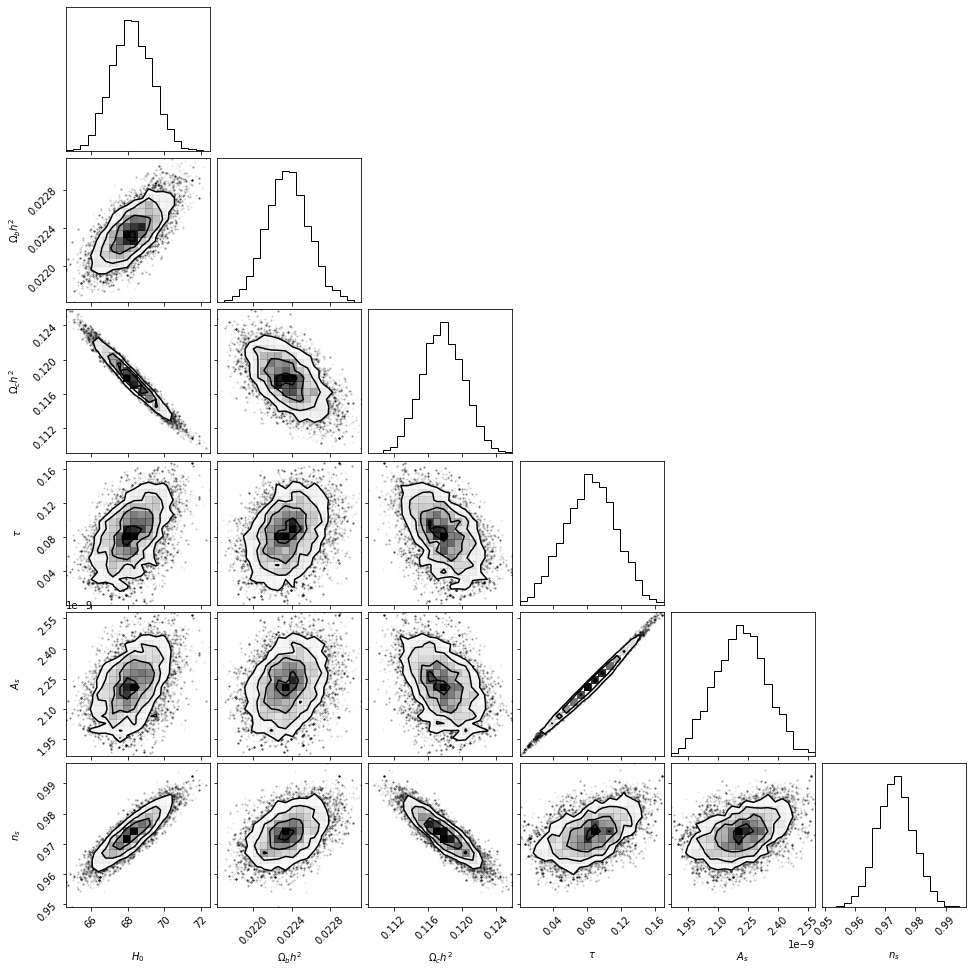

In [18]:
figure = corner.corner(samples.T,labels=par)

And the estimation of the parameters with their uncertainties are the following:

In [121]:
parr=[r'H_0',r'Omega_b h^2',r'Omega_c h^2',r'tau',r'A_s',r'n_s']
for i in range(len(samples)):
    print(r'The estimation for '+parr[i]+'='+str(np.mean(samples[i]))+
          r' with error:'+str(np.std(samples[i])))

The estimation for H_0=68.23136560956435 with error:1.0973647667228792
The estimation for Omega_b h^2=0.02235838108619997 with error:0.00021950671608967346
The estimation for Omega_c h^2=0.1177340217127854 with error:0.0024278126238312155
The estimation for tau=0.08356992190162157 with error:0.02998685615091737
The estimation for A_s=2.2145843746879562e-09 with error:1.2611974772802786e-10
The estimation for n_s=0.9734267864131818 with error:0.005991863070678401


Using the formulation for a spatially flat universe, we will have that $\Omega_{\Lambda}=1-(\Omega_{c}h^{2}+\Omega_{b}h^{2})\frac{100^{2}}{H_{0}^{2}}$. And the error can be estimated using the partial derivatives of $\Omega_{\Lambda}$ respect to the parameters obtained from the MCMC
$\Delta \Omega_{\Lambda}=\sqrt{(\frac{\partial \Omega_{\Lambda}}{\partial\Omega_{c}h^{2}})^{2}(\Delta{\Omega_{c}h^{2}})^{2}+(\frac{\partial \Omega_{\Lambda}}{\partial\Omega_{b}h^{2}})^{2}(\Delta{\Omega_{b}h^{2}})^{2}+(\frac{\partial \Omega_{\Lambda}}{\partial H_{0}})^{2}(\Delta{H_{0}})^{2}}$ (considering $\Delta m=\sigma_{m}$ for each parameter).

In [70]:
Ol=1-(np.mean(Ob)+np.mean(Oc))*(100**2)/(np.mean(H0)**2)

In [71]:
sOl=(100**2)*np.sqrt(((np.std(Ob)**2)+(np.std(Oc)**2))/(np.mean(H0)**4)+
                 ((np.std(H0)**2)*2*((np.mean(Ob)+np.mean(Oc))**2))/(np.mean(H0)**6))

In [72]:
Ol,sOl,Ol+sOl

(0.6990831845226845, 0.008617536185061251, 0.7077007207077457)

The estimation for the dark energy was $\Omega_{\Lambda}=0.699\pm0.7077$

Now, we can define weights to do importance sampling using the prior distribution for the optical depth $\tau=0.0540\pm0.0074$. If we consider that the posterior distributions obtained using MCMC are Gaussians and the new prior is also a Gaussian ($G$), we can define the weigths:
$$w_{i}=\frac{G(\tau_{i}|0.0540, 0.0074)}{G(\tau_{i}|\bar{\tau}_{MCMC}, \sigma_{\tau MCMC})}$$. 
Then, the estimation of each parameter in the chain using the importance sampling with the weights is $<m>=\frac{\sum_{i}w_{i}m_{i}}{\sum_{i}w_{i}}$. Also $<m^{2}>=\frac{\sum_{i}w_{i}m_{i}^{2}}{\sum_{i}w_{i}}$, and then, $\sigma_{m}=\sqrt{<m^{2}>-<m>^{2}}$.

In [73]:
ptau_old=np.exp(-((tau-np.mean(tau))/np.std(tau))**2)

In [74]:
ptau_new=np.exp(-((tau-0.0540)/0.0074)**2)

In [80]:
wi=ptau_new/ptau_old

In [87]:
means=(samples@wi)/sum(wi)

In [88]:
meanssq=((samples**2)@wi)/sum(wi)

In [89]:
errsi=np.sqrt(meanssq-means**2)

The estimation of the parameters using importance sampling are the following:

In [122]:
for i in range(len(samples)):
    print(r'The estimation for '+parr[i]+'='+str(means[i])+
          r' with error:'+str(errsi[i]))

The estimation for H_0=67.73133129924331 with error:1.0520689969219863
The estimation for Omega_b h^2=0.022288421089291775 with error:0.0002129960562668949
The estimation for Omega_c h^2=0.11879595144153415 with error:0.0023797468563476515
The estimation for tau=0.05288371159474349 with error:0.005340468268458898
The estimation for A_s=2.0856005001653924e-09 with error:2.416685352403217e-11
The estimation for n_s=0.9705314751136545 with error:0.005791619596947485


We can restimate the covariance matrix using $N_{m}=(A'(<m>)N^{-1}A'(<m>))^{-1}$ for $<m>$ from the importance sampling that I just did.

In [95]:
y,der=deriv(ev_planck,means,hh)
A_m=np.ones([y.size,6])
for i in range(6):
    A_m[:,i]=der[i]

In [97]:
Nmm=np.linalg.inv(A_m.T@Ninv@A_m)

In [98]:
Nmm

array([[ 1.37789509e+00,  1.92985369e-04, -3.03110424e-03,
         2.33610676e-02,  8.23786070e-11,  6.53112379e-03],
       [ 1.92985369e-04,  5.28631944e-08, -3.58200828e-07,
         3.40690959e-06,  1.25621624e-14,  7.18407451e-07],
       [-3.03110424e-03, -3.58200828e-07,  7.00491063e-06,
        -5.11083453e-05, -1.77648786e-13, -1.49137543e-05],
       [ 2.33610676e-02,  3.40690959e-06, -5.11083453e-05,
         1.36728653e-03,  5.43008831e-12,  1.16804645e-04],
       [ 8.23786070e-11,  1.25621624e-14, -1.77648786e-13,
         5.43008831e-12,  2.17085416e-20,  4.04178701e-13],
       [ 6.53112379e-03,  7.18407451e-07, -1.49137543e-05,
         1.16804645e-04,  4.04178701e-13,  4.00938917e-05]])

Below I defined a routine named prior to evaluate the trial step value of $\tau$ in the Gaussian distribution $G(\tau_{i}|0.0540, 0.0074)$

In [38]:
def prior(theta):
        return np.exp(-((theta[3]-0.0540)/0.0074)**2)

I redefined the routine to run a chain as run_mcmc_p, this routine includes the prior information defined in the routine prior. Thus, the new probability in each step $k$ is now $e^{-0.5\Delta{\chi^{2}}}\frac{prior(t_{k})}{prior(t_{k-1})}$.

In [99]:
def run_mcmc_p(data,start_pos,nstep,Nm,scale=None):
    nparam=start_pos.size
    params=np.zeros([nstep,nparam+1])
    params[0,0:-1]=start_pos
    cur_chisq=chi2(start_pos,data)
    params[0,-1]=cur_chisq
    cur_pos=start_pos.copy()
    if scale[0]==None:
        scale=np.ones(nparam)
    naccept=0
    accept_rate=np.zeros(nstep)
    for i in range(1,nstep):
        new_pos=cur_pos+noise(Nm)*scale
        new_chisq=chi2(new_pos,data)
        #print('Step:',i)
        delt=new_chisq-cur_chisq
        prob=prior(new_pos)*np.exp(-0.5*delt)/prior(cur_pos)
        #print('prob='+str(prob))
        if np.random.rand()<prob:
                accept=True
        else:
                accept=False
        if accept:
            cur_pos=new_pos
            cur_chisq=new_chisq
            naccept += 1

        accept_rate[i] = naccept / i
        #print('acc rate:'+str(accept_rate[i]))
        params[i,0:-1]=cur_pos
        params[i,-1]=cur_chisq
        #print(params[i])
        with open('planck_chain_tauprior.txt', 'a') as f:
            f.write(str(cur_chisq)+' ')
            for j in cur_pos[0:-1]:
                f.write(str(j)+' ') 
            f.write(str(cur_pos[-1])+'\n')
    return params

In [102]:
chain1=run_mcmc_p(spec,parrs,25000,Nmm,np.array([0.7,0.7,0.7,0.4,0.4,0.7]))

In [103]:
fl1=open('planck_chain_tauprior.txt')
chain1=np.array([(x.strip()).split(' ') for x in fl1.readlines()],dtype='float64')
fl1.close()

In [104]:
chi21=np.array([chain1[j][0] for j in range(0,len(chain1))])
H01=np.array([chain1[j][1] for j in range(0,len(chain1))])
Ob1=np.array([chain1[j][2] for j in range(0,len(chain1))])
Oc1=np.array([chain1[j][3] for j in range(0,len(chain1))])
tau1=np.array([chain1[j][4] for j in range(0,len(chain1))])
As1=np.array([chain1[j][5] for j in range(0,len(chain1))])
ns1=np.array([chain1[j][6] for j in range(0,len(chain1))])

Text(0.5, 0, 'step')

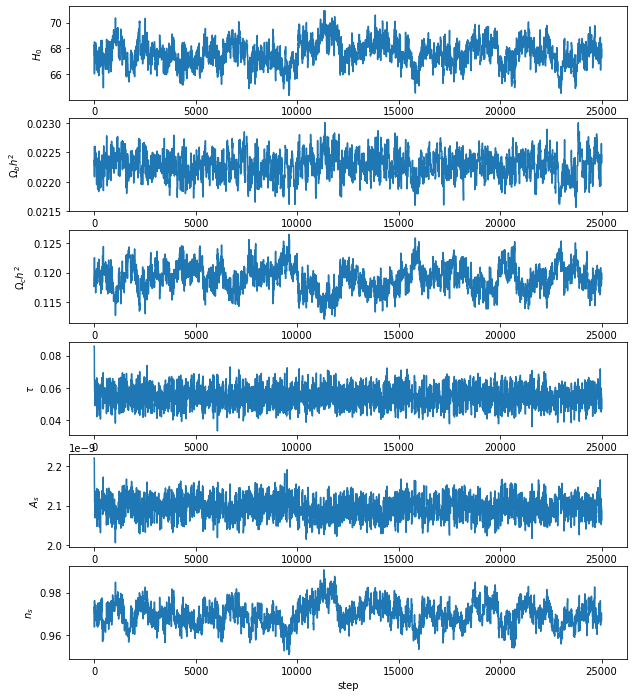

In [107]:
f,ax=plt.subplots(6,1,figsize=(10,12))
par=['$H_{0}$','$\Omega_{b}h^{2}$','$\Omega_{c}h^{2}$',r'$\tau$','$A_{s}$','$n_{s}$']
for i in range(1,7):
    ax[i-1].plot([chain1[j][i] for j in range(0,len(chain1))],'-')
    ax[i-1].set_ylabel(par[i-1])
    #ax[i-1].set_xlim(0,25000)
plt.xlabel('step')

In [108]:
samples1=np.array([H01,Ob1,Oc1,tau1,As1,ns1])

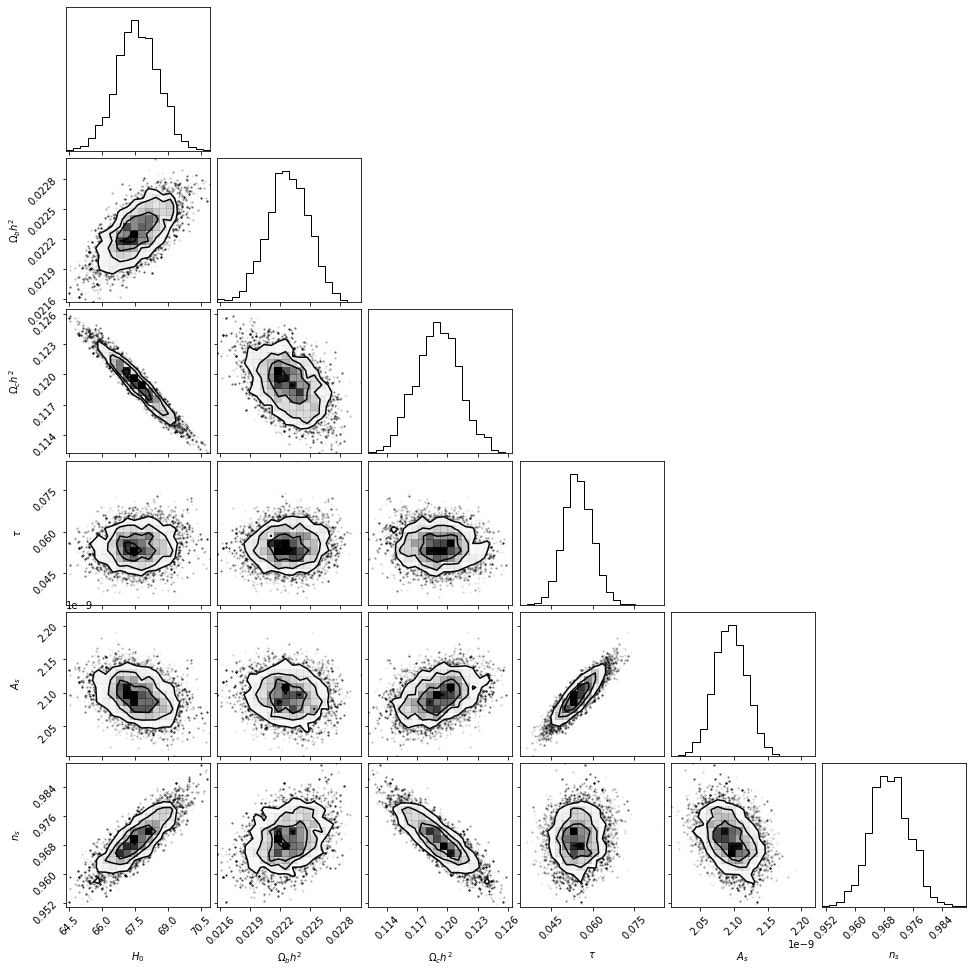

In [109]:
figure1 = corner.corner(samples1.T,labels=par)

The new set of parameters using the prior information is:

In [118]:
for i in range(len(samples1)):
    print(r'The estimation for '+parr[i]+'='+str(np.mean(samples1[i]))+
          r' with error:'+str(np.std(samples1[i])))

The estimation for H_0=67.61572079584533 with error:0.9543111784957445
The estimation for Omega_b h^2=0.022275331251134352 with error:0.00020756084149584837
The estimation for Omega_c h^2=0.11905167357470824 with error:0.002189197371554165
The estimation for tau=0.05471969559559261 with error:0.00510230826913746
The estimation for A_s=2.094890407757391e-09 with error:2.352825656303212e-11
The estimation for n_s=0.9696847297738862 with error:0.0054369523058007485


The absolute differences from what we obtained using importance sampling are:

In [119]:
for i in range(len(samples1)):
    print(r'The absolute difference for '+parr[i]+'='+
          str(np.abs(np.mean(samples1[i])-means[i])))

The absolute difference for H_0=0.11561050339797418
The absolute difference for Omega_b h^2=1.308983815742279e-05
The absolute difference for Omega_c h^2=0.00025572213317408277
The absolute difference for tau=0.0018359840008491182
The absolute difference for A_s=9.289907591998539e-12
The absolute difference for n_s=0.0008467453397682512


We can see that the differences from what we obtained using the prior information for MCMC and the importance sampling are of the order of magnitude $<\sigma_{m}$ (less than the estimated error) for each parameter $m$. Therefore, if we already ran our chain but we know new prior information, using importance sampling could be a good approximation of what we will be obtaining if we run a new chain including the prior information.

We can compare what we obtained between the two chains to see that this difference is larger than the difference of comparing the estimations from the chain with prior information and the estimations from the importance sampling.

In [120]:
for i in range(len(samples1)):
    print(r'The absolute difference for '+parr[i]+'='+
          str(np.abs(np.mean(samples1[i])-np.abs(np.mean(samples[i])))))

The absolute difference for H_0=0.6156448137190154
The absolute difference for Omega_b h^2=8.304983506561905e-05
The absolute difference for Omega_c h^2=0.0013176518619228417
The absolute difference for tau=0.028850226306028966
The absolute difference for A_s=1.1969396693056532e-10
The absolute difference for n_s=0.00374205663929561
